In [1]:
#imports
#machine learning core
import tensorflow as tf
import os
import librosa
#data visualization
import IPython.display as display
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False
import tensorflow_hub as hub
#generalpupose imports
import numpy as np
import PIL.Image
import time
import functools

In [2]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [3]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

In [4]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [5]:
content = load_img('country00002.png')
style = load_img('blues00020.png')

(1, 341, 512, 3) (1, 341, 512, 3)


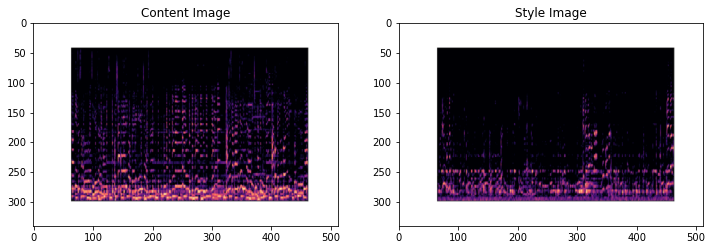

In [6]:
plt.subplot(1, 2, 1)
imshow(content, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
print(content.shape,style.shape)

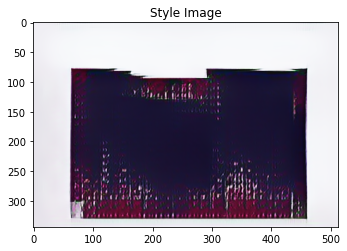

In [7]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content), tf.constant(style))[0]
plt.subplot(1, 2, 2)
imshow(stylized_image, 'Style Image')

In [8]:
import librosa
import numpy as np
import IPython.display as ipd
import scipy.io.wavfile as wavfile

In [9]:
class AudioStuff:
    
    def __init__(self, filename):
        self.filename = filename
        
    def audio_to_spectrogram(self):
        audio, sr = librosa.load(self.filename)
        D = np.abs(librosa.stft(audio))**2
        audio= librosa.feature.melspectrogram(y=audio, sr=sr, S=D)
        return (audio, sr)

In [10]:
class SpectrogramStuff:
    def __init__(self, spectrogram1, spectrogram2):
        self.spectrogram1 = spectrogram1
        self.spectrogram2 = spectrogram2
        
    def MergeSpectrogram(self):
        return (self.spectrogram1 + self.spectrogram2)/2

In [11]:
class LossFunctions:
    def __init__(self, mel_targets, mel_outputs):
        self.mel_targets = mel_targets 
        self.mel_outputs = mel_outputs
    
    def loss_c_func(self):
        tf.losses.mean_squared_error(self.mel_targets, self.mel_outputs)
        
    def loss_s_function(self):
        tf.losses.mean_squared_error(tf.matmul(self.mel_targets, ), tf.matmul(self.mel_outputs, ))

In [12]:
def spectrogram_to_audio(spectrogram):
    res = librosa.feature.inverse.mel_to_audio(spectrogram)
    return res

In [13]:
if __name__ == '__main__':
    content_object = AudioStuff("vocals.wav")
    style_object = AudioStuff("accompaniment.wav")
    content_spectrogram, content_rate = content_object.audio_to_spectrogram()
    style_spectrogram, style_rate = style_object.audio_to_spectrogram()
    #print(content_spectrogram.shape)
    #print(style_spectrogram)
    object1 = SpectrogramStuff(content_spectrogram, style_spectrogram)
    print(object1.MergeSpectrogram().shape)
    #content_audio = spectrogram_to_audio(content_spectrogram)
    merge_spectrogram = stylized_image
    merge_audio = spectrogram_to_audio(merge_spectrogram)
    #style_audio = spectrogram_to_audio(style_spectrogram)
    wavfile.write("OUTPUT/outp3.wav", style_rate, merge_audio)

/Users/thuhin/opt/anaconda3/envs/spleeter/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'vocals.wav'

In [15]:
spectrogram_to_audio(stylized_image)

TypeError: Cannot interpret 'tf.float32' as a data type

In [89]:
x = tf.keras.applications.vgg19.preprocess_input(content*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 155s 0us/step


TensorShape([1, 1000])

In [10]:
N_FILTERS = 4096
#https://keras.io/api/layers/ add layers from here basic conv2d layer was enou
# filter shape is "[filter_height, filter_width, in_channels, out_channels]" add img size, random placeholder nums here
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(N_FILTERS, (3, 3), activation='relu',))
model.add(tf.keras.layers.Conv2D(N_FILTERS, (3, 3), activation='relu'))
#model.add(layers.ConvLSTM2D())


In [11]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
model.fit(style)
model.summary()

Train on 1 samples
1/1 [==============================] - 0s 127ms/sample


IndexError: list index out of range

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

In [50]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)